# Fashion MNIST

In this question, we are to build a multi-class classification model using a convolutional neural
network for the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article
images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each
example is a 28x28 grayscale image associated with a label from 10 classes.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report

import torchmetrics

import seaborn as sns

In [127]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [128]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root='./data', train=True,
download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False,
download=True, transform=transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train, val = random_split(train_dataset, [train_size, val_size],generator=generator)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
val_loader = DataLoader(val, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Calculate the mean and standard deviation of the training dataset
all_pixels = torch.cat([data[0].view(-1) for data in train_loader], dim=0)
mean = all_pixels.mean().item()
std = all_pixels.std().item()

print(f"Mean: {mean}, Std: {std}")

# Normalize the dataset using the calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

Mean: 0.28570690751075745, Std: 0.35282522439956665


Labels Each training and test example is assigned to one of the following labels as shown below:

- 0 : T-shirt/top
- 1 : Trouser
- 2 : Pullover
- 3 : Dress
- 4 : Coat
- 5 : Sandal
- 6 : Shirt
- 7 : Sneaker
- 8 : Bag
- 9 : Ankle boot

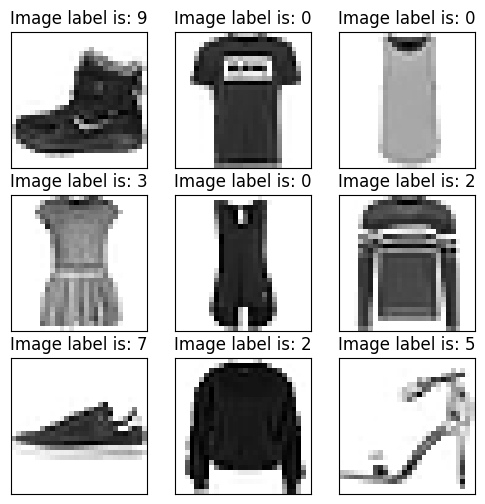

In [129]:
plt.figure(figsize=(6,6))
for i in range(9):
    image, label = train_dataset[i]
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.title("Image label is: {}".format(label))
plt.show()

### CNN Model

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [131]:
class CNNModel(nn.Module):
    def __init__(self,in_channels=1, num_classes=10):
        super(CNNModel, self).__init__()

        # First convolutional block:
        #  - Conv layer with 32 filters of size 3x3
        #  - ReLU activation
        #  - 2x2 Max pooling (downsamples spatial dims)
        #  - Batch normalization to stabilize training
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels= 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32)
        )

        # Second convolutional block:
        #  - Conv layer with 64 filters
        #  - ReLU + Max pooling + BatchNorm again
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64)
        )

        # Fully connected classifier:
        #  - Flatten the 64×7×7 output to a vector
        #  - Dense layer with 128 units + ReLU
        #  - Dropout for regularization
        #  - Final linear layer outputs logits for classification
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
      x = self.conv1(x)
      x = self.conv2(x)
      x = self.classifier(x)
      return x

In [132]:
model = CNNModel().to(device)
print(model)

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [133]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [134]:
num_epochs = 10

patience = 3
best_val_acc = 0.0
epochs_since_improvement = 0

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # Log
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
        break

Epoch [1/10] | Train Loss: 0.3648 | Train Acc: 86.85% | Val Acc: 89.93%
Epoch [2/10] | Train Loss: 0.2418 | Train Acc: 91.15% | Val Acc: 90.85%
Epoch [3/10] | Train Loss: 0.2006 | Train Acc: 92.66% | Val Acc: 92.08%
Epoch [4/10] | Train Loss: 0.1698 | Train Acc: 93.72% | Val Acc: 91.88%
Epoch [5/10] | Train Loss: 0.1485 | Train Acc: 94.41% | Val Acc: 91.19%
Epoch [6/10] | Train Loss: 0.1257 | Train Acc: 95.18% | Val Acc: 92.12%
Epoch [7/10] | Train Loss: 0.1104 | Train Acc: 95.82% | Val Acc: 92.13%
Epoch [8/10] | Train Loss: 0.1004 | Train Acc: 96.29% | Val Acc: 91.20%
Epoch [9/10] | Train Loss: 0.0876 | Train Acc: 96.67% | Val Acc: 91.85%
Epoch [10/10] | Train Loss: 0.0774 | Train Acc: 97.07% | Val Acc: 92.38%


In [135]:
model.eval()
running_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

epoch_loss = running_loss / len(test_loader)
epoch_acc = 100 * correct / total
print(f"Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%")

Test Loss: 0.2982 | Test Accuracy: 92.12%


#### Confusion Matrix

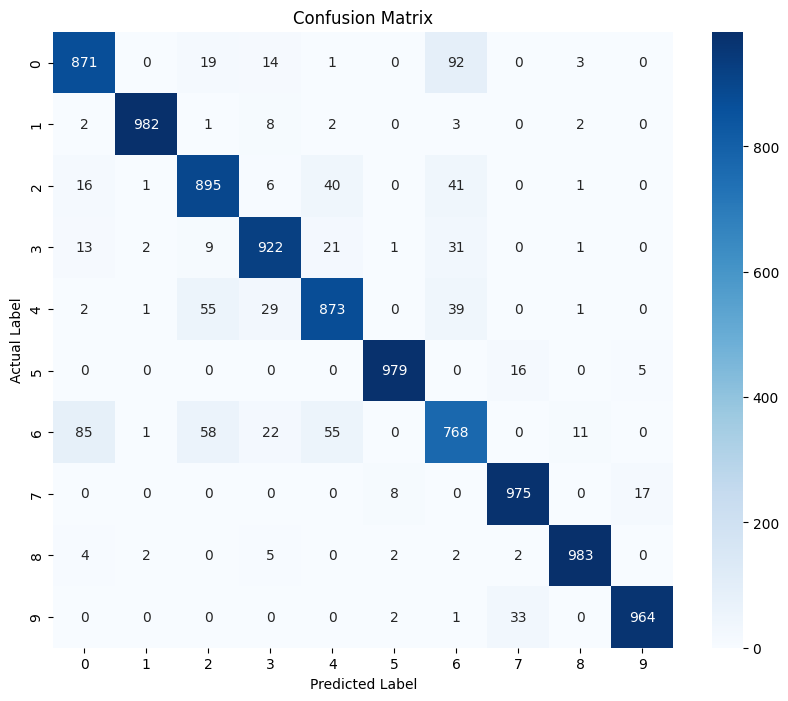

In [136]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

### Multi Class Classification - Aggregation Method

- Micro :
  - Counts total true positives, false positives, and false negatives across all classes.
  - Computes precision and recall from those totals.
  - Gives equal weight to each instance.

- Macro :
  - Computes precision and recall for each class independently, then takes the average.
  - Gives equal weight to each class, regardless of how many samples it has.

- Weighted
  - Computes per class precision and recall.
  - Takes the average weighted by the number of instances in each class.



In [137]:
from collections import Counter
y_train = train_dataset.targets
y_train_list = y_train.tolist()
class_counts = Counter(y_train_list)
print(class_counts)

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


Since the  dataset is balanced, I will choose Macro since Macro treats all classes equally. I would wanat to evaluate class-wise fairness which can gives me a better sense of whether the CNN model is consistently good across all types of clothing items.


In [138]:
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")

Macro Precision: 0.9212
Macro Recall: 0.9212


### Model with Two Branches

In [139]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [140]:
class TwoBranchCNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(TwoBranchCNN, self).__init__()

         # Branch 1: Three 3×3 convolutions
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Branch 2: Capture wider kernels initially to capture broader context, followed by 3×3
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )

        # Global average pooling to ensure same output size before concatenation
        self.global_pool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear((128 + 64) * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        b1 = self.branch1(x)
        b2 = self.branch2(x)
        b1 = self.global_pool(b1)
        b2 = self.global_pool(b2)
        x = torch.cat([b1, b2], dim=1)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

In [141]:
model2 = TwoBranchCNN(in_channels=1, num_classes=10)
print(model2)
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

TwoBranchCNN(
  (branch1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (branch2): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, st

In [142]:
num_epochs = 10

patience = 3

best_val_acc = 0.0
epochs_since_improvement = 0

for epoch in range(num_epochs):
    # Train
    model2.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model2.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total

    # Log
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    if epochs_since_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} (no improvement for {patience} epochs).")
        break

Epoch [1/10] | Train Loss: 0.3674 | Train Acc: 86.82% | Val Acc: 90.33%
Epoch [2/10] | Train Loss: 0.2494 | Train Acc: 90.88% | Val Acc: 92.29%
Epoch [3/10] | Train Loss: 0.2087 | Train Acc: 92.34% | Val Acc: 92.05%
Epoch [4/10] | Train Loss: 0.1849 | Train Acc: 93.23% | Val Acc: 92.42%
Epoch [5/10] | Train Loss: 0.1612 | Train Acc: 94.15% | Val Acc: 92.86%
Epoch [6/10] | Train Loss: 0.1408 | Train Acc: 94.76% | Val Acc: 92.72%
Epoch [7/10] | Train Loss: 0.1250 | Train Acc: 95.28% | Val Acc: 92.72%
Epoch [8/10] | Train Loss: 0.1118 | Train Acc: 95.82% | Val Acc: 93.28%
Epoch [9/10] | Train Loss: 0.0989 | Train Acc: 96.24% | Val Acc: 93.19%
Epoch [10/10] | Train Loss: 0.0858 | Train Acc: 96.70% | Val Acc: 93.16%


In [143]:
model2.eval()
running_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model2(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

epoch_loss = running_loss / len(test_loader)
epoch_acc = 100 * correct / total
print(f"Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc:.2f}%")

Test Loss: 0.2914 | Test Accuracy: 92.62%


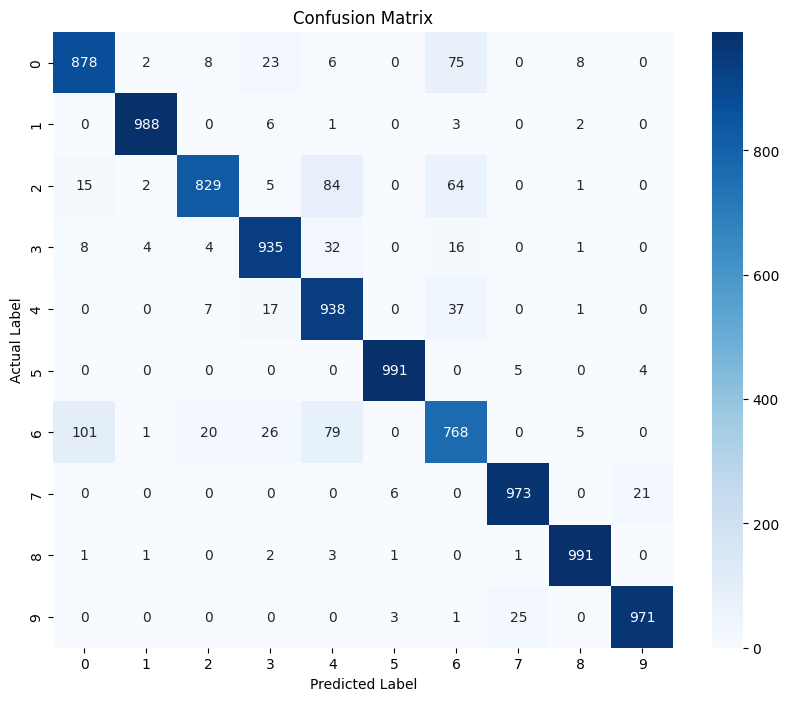

In [144]:
all_preds = []
all_labels = []

model2.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

In [145]:
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")

Macro Precision: 0.9276
Macro Recall: 0.9262
